In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_kernels
from tslearn.metrics import dtw
from fastdtw import fastdtw
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('mitbih_train.csv', header=None)

# 数据平衡
train_sample_num = 200

df_1 = df[df[187] == 1]
df_2 = df[df[187] == 2]
df_3 = df[df[187] == 3]
df_4 = df[df[187] == 4]
df_0 = (df[df[187] == 0]).sample(n=train_sample_num, random_state=42)
df_1_upsample = resample(df_1, replace=True, n_samples=train_sample_num, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=train_sample_num, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=train_sample_num, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=train_sample_num, random_state=126)
df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

X_train = df.iloc[:, :-1].values.reshape(-1, 187)  # 将数据重塑为[batch_size, 1, 187]的形状
y_train = df.iloc[:, -1].values.astype(int)

print(X_train.shape)

(1000, 187)


In [3]:
# 加载测试集
df = pd.read_csv('mitbih_test.csv', header=None)

# 测试集数据平衡
test_sample_num = 20

df_1 = df[df[187] == 1]
df_2 = df[df[187] == 2]
df_3 = df[df[187] == 3]
df_4 = df[df[187] == 4]
df_0 = (df[df[187] == 0]).sample(n=test_sample_num, random_state=42)
df_1_upsample = resample(df_1, replace=True, n_samples=test_sample_num, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=test_sample_num, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=test_sample_num, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=test_sample_num, random_state=126)
df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

X_test = df.iloc[:, :-1].values.reshape(-1, 187)  # 将数据重塑为[batch_size, 1, 187]的形状

y_test = df.iloc[:, -1].values.astype(int)


In [4]:
def dtw_distance(x, y):
    distance, path = fastdtw(x, y)
    return distance

start = time.time()
dist_mat_train = cdist(X_train, X_train, metric=dtw_distance)
dist_mat_test = cdist(X_test, X_train, metric=dtw_distance)
end = time.time()
print("Cal time:", end-start)

Cal time: 506.3583710193634


In [5]:

# Compute the cauchy kernel with DTW distance for the training and testing sets
c = 1
K_train = 1-((dist_mat_train**2)/(dist_mat_train**2+c))
K_test = 1-((dist_mat_test**2)/(dist_mat_test**2+c))


In [6]:
print("Train:", 5*train_sample_num, "Test:", 5*test_sample_num, "Cal time:", end-start)

# Train SVM with combined kernel matrix
model = SVC(kernel='precomputed')

model.fit(K_train, y_train)

# Predict on new data
y_pred = model.predict(K_test)

print("Accuracy:", np.mean(y_pred == y_test))

Train: 1000 Test: 100 Cal time: 506.3583710193634
Accuracy: 0.84


<AxesSubplot:>

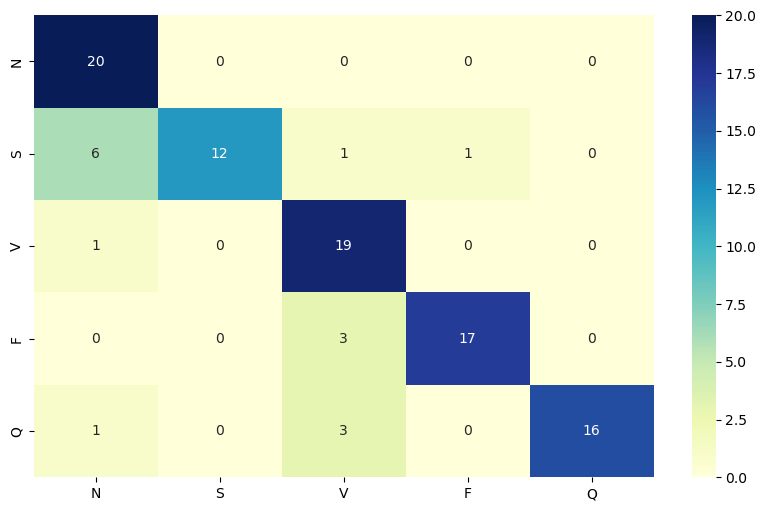

In [7]:
Y_prediction = model.predict(K_test)
#image
cm= confusion_matrix(y_test,Y_prediction)
index = ['N','S','V','F','Q'] 
columns = ['N','S','V','F','Q']   
cm_df = pd.DataFrame(cm,columns,index) 
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d",cmap="YlGnBu")